In [ ]:
!pip install arabert

In [ ]:
!pip install swifter

In [ ]:
import re
import pandas as pd
import swifter
import torch
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from arabert.preprocess import ArabertPreprocessor
from joblib import Parallel, delayed, parallel_config
import gc
from tqdm.auto import tqdm
import os
import difflib

In [ ]:
file_path = 'Dataset.xlsx'
df = pd.read_excel(file_path)
df

,Number,Date,City,Facts,Reasons,Judgment,Type,Label
0,٥٧١,١٠/٥/١٤٤٠,المدينة المنورة,تتلخص وقائع هذه الدعوى في أنه تقدم إلى المحكمة...,وحيث إن الواجب بحث الاختصاص القضائي قبل الخوض ...,أمين السرأيمن بن عبد العزيز الصبحي عضو إبراهيم...,الاجاره,مرفوضه
1,٤٥٣٠٠٩١٤٨٧,٢٨/٧/١٤٤٤,الدمام,تتلخص وقائع هذه الدعوى بالقدر اللازم لإصدار هذ...,لما كان النزاع بين المدعية والمدعى عليها ناشئ ...,حكمت الدائرة بما يلي : أولا / عدم جواز نظر طلب...,البيع,مرفوضه
2,٤٦٣٠٠٦٦٣٤٣,٢٢/١/١٤٤٦,جدة,تتلخص وقائع الدعوى بالقدر اللازم لإصدار الحكم ...,فبناء على ما تقدم ؛ وبما أن الدائرة تختص في نظ...,قررت الدائرة : قبول الطلب المدعي : ، وسماع شها...,الاجاره,مقبوله
3,٤٤٣٠٥٢٩٣٠٤,٥/٧/١٤٤٤,منطقة مكة المكرمة,تتلخص وقائع هذه الدعوى في أن المدعي يطلب إيداع...,وحيث اطلعت الدائرة على مرفقات القضية وحكم التح...,حكمت الدائرة : بقبول طلب إيداع حكم التحكيم الص...,البيع,مقبوله
4,١٧٥٨٤,٢٦/١٠/١٤٤١,الدمام,فقد ورد للدائرة قرار دائرة الاستئناف التجارية ...,بالاطلاع على ما ذكر تبين أن الدائرة أجابت عليه...,قررت الدائرة : إحالة القضية إلى دوائر الاستئنا...,البيع,مرفوضه
...,...,...,...,...,...,...,...,...
19864,٢٢٤٤/٣/ق,٢/٨/١٤٣٩,الدمام,تتحصل وقائع هذه القضية بالقدر اللازم لإصدار هذ...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,برفض الدعوى المقامة من المدعي / (...) – هوية و...,نظر الدعوى,مرفوضه
19865,١٤٤٨٧/٣/ق,٤ / ٣ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى بالقدر اللازم لإصدار هذ...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,) بإلزام (...) ويحمل الهوية الوطنية رقم (...) ...,نظر الدعوى,مقبوله
19866,١٧٧٢٠,٢٥ / ٢ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى بالقدر اللازم لإصدار ال...,وبعد سماع الدعوى والاطلاع على أوراق القضية ومس...,: بإلزام المدعى عليها / (...)- هوية وطنية (......,نظر الدعوى,مقبوله
19867,٩٦١٦/٣/ق,١٣ / ١ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى حسبما تفحص الأوراق في أ...,بعد سماع الدعوى والاطلاع على أوراق القضية ومست...,غيابيا بإلزام المدعى عليها / شركة (...) العربي...,نظر الدعوى,مقبوله


In [ ]:
df['Label'].value_counts()

,count
Label,
مرفوضه,9958
مقبوله,9911


In [ ]:
label_counts = df["Label"].value_counts()
majority_label = label_counts.idxmax()
minority_label = label_counts.idxmin()

In [ ]:
excess_count = label_counts[majority_label] - label_counts[minority_label]

majority_df = df[(df["Label"] == majority_label) & (df["Type"] == "نظر الدعوى")]

to_remove = majority_df.sample(n=excess_count, random_state=42)

df = df.drop(to_remove.index)
print(df["Label"].value_counts())

Label
مرفوضه    9911
مقبوله    9911
Name: count, dtype: int64


## Model

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
seq_len = [len(tokenizer.encode(text, truncation=False)) for text in df["Facts"].dropna().tolist()]

Token indices sequence length is longer than the specified maximum sequence length for this model (3317 > 512). Running this sequence through the model will result in indexing errors


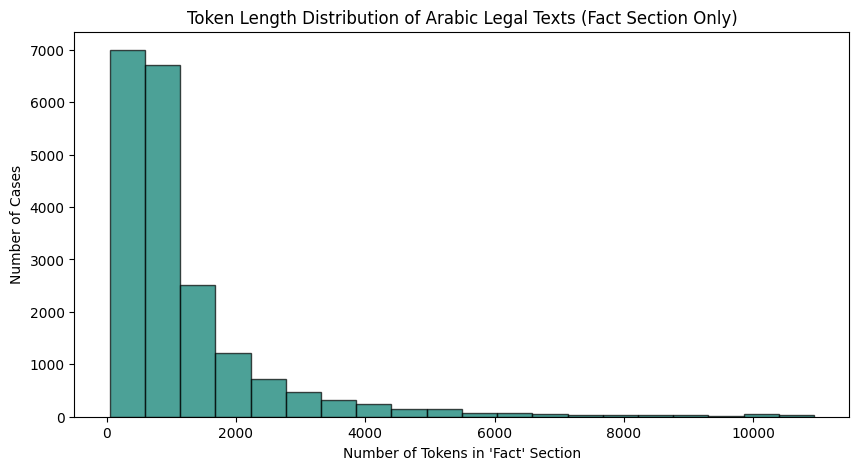

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(seq_len, bins=20, alpha=0.7, color='#00796B', edgecolor='black')
plt.xlabel("Number of Tokens in 'Fact' Section")
plt.ylabel("Number of Cases")
plt.title("Token Length Distribution of Arabic Legal Texts (Fact Section Only)")
plt.savefig("tokens1.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

min_len = np.min(seq_len)
max_len = np.max(seq_len)
mean_len = np.mean(seq_len)

print("Min token length (Fact):", min_len)
print("Max token length (Fact):", max_len)
print("Mean token length (Fact):", round(mean_len, 0))

Min token length (Fact): 48
Max token length (Fact): 10940
Mean token length (Fact): 1211.0


# PreProcessing

In [ ]:
arabert_prep = ArabertPreprocessor(model_name=model_name)

def custom_preprocess(text):
    if not isinstance(text, str):
        return ""  

    text = arabert_prep.preprocess(text)

    text = re.sub(r'[^\w\s.,،]', '', text)

    text = re.sub(r'[A-Za-z]+', '', text)

    text = re.sub(r'(\.\s*){2,}', '', text)  

    return text

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [08:16<00:00, 486kiB/s]


[2025-04-15 03:00:10,175 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
custom_preprocess("تتلخص وقائع هذه الدعوى في أنه تقدم إلى المحكمة العامة بالمدينة المنورة وكيل المدعية بلائحة ادعاء يختصم فيها المدعى عليه قيدت القضية بالرقم المشار إليه أعلاه وأحيلت إلى هذه الدائرة , وتم تحديد جلسة هذا اليوم موعدا لنظرها , وفيها حضر وكيل المدعية (...)، سعودي الجنسية ، هوية وطنية رقم (...) بموجب الوكالة رقم (...) والمصادق عليها من سفارة المملكة العربية السعودية في (...) بتاريخ ١٤ / ١ / ١٤٤٠هـ والمصادق عليها من وزارة العدل بتاريخ ٧ / ٥ / ١٤٤٠ه ، كما حضرت وكيلة المدعى عليه (...)، سعودية الجنسية ، هوية وطنية رقم (...) بموجب الوكالة رقم (...) في ٩ / ٠٢ / ١٤٤٠هـ الصادرة من كتابة العدل بشرق الرياض ، وفيها سألت الدائرة وكيل المدعية عن دعوى موكلته فقدم المذكرة المشار إلى بياناتها في الضبط وأحال عليها ثم استوضحت الدائرة منه عن حقيقة النزاع فأجاب بأن موكلته استأجرت مدينة ألعاب بغرض استثمارها من المؤجر (...) وتعاقدت مع المدعى عليه على أن يقوم المدعى عليه بتشغيل العقار ويدفع أجرة التشغيل لموكلته على أربع دفعات سنويا قدرها ثمان مئة ألف ريال في السنة الأولى ثم تزيد كل سنة بواقع ثلاثين بالمئة لمدة خمس سنوات , ثم قرر الاكتفاء بهذا القدر ولصلاحية الدعوى للفصل فيها قررت الدائرة الحكم في الدعوى لما يلي من الأسباب .")

'تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال محكم ة ال عام ة ب ال مدين ة ال منور ة وكيل ال مدعي ة ب لائح ة ادعاء يختصم في ها ال مدعى علي ه قيد ت ال قضي ة ب ال رقم ال مشار إلي ه أعلا ه و أحيل ت إلى هذه ال دائر ة , و تم تحديد جلس ة هذا ال يوم موعد ا ل نظر ها , و في ها حضر وكيل ال مدعي ة  ، سعودي ال جنسي ة ، هوي ة وطني ة رقم  ب موجب ال وكال ة رقم  و ال مصادق علي ها من سفار ة ال مملك ة ال عربي ة ال سعودي ة في  ب تاريخ 14  1  1440 ه و ال مصادق علي ها من وزار ة ال عدل ب تاريخ 7  5  1440 ه ، كما حضر ت وكيل ة ال مدعى علي ه  ، سعودي ة ال جنسي ة ، هوي ة وطني ة رقم  ب موجب ال وكال ة رقم  في 9  02  1440 ه ال صادر ة من كتاب ة ال عدل ب شرق ال رياض ، و في ها سأل ت ال دائر ة وكيل ال مدعي ة عن دعوى موكل ت ه ف قدم ال مذكر ة ال مشار إلى بيان ات ها في ال ضبط و أحال علي ها ثم استوضح ت ال دائر ة من ه عن حقيق ة ال نزاع ف أجاب ب أن موكل ت ه استأجر ت مدين ة ألعاب ب غرض استثمار ها من ال مؤجر  و تعاقد ت مع ال مدعى علي ه على أن يقوم ال مدعى علي ه ب تشغيل ال عقار و يدفع أجر ة ال تشغيل ل موكل ت ه على أربع دفع ات سن

In [ ]:
df['Facts'] = df['Facts'].swifter.apply(custom_preprocess)

# Toknizer

In [ ]:
def split_text(text, tokenizer, max_tokens=510, overlap=20):
    """ Smart Arabic-aware text segmentation with punctuation-based splits & overlap handling """
    tokens = tokenizer.tokenize(text)
    segments = []
    start = 0
    total_tokens = len(tokens)
    covered_indices = set()

    while start < total_tokens:
        end = min(start + max_tokens, total_tokens)

        while (
            end < total_tokens
            and tokens[end].startswith("##")
            and not tokens[end-1].isdigit()  
        ):
            end -= 1

        split_pos = None
        for i in range(end-1, max(start, end-50)-1, -1):  
            if tokens[i] in {'.', '،'}:  
                if i+1 < len(tokens) and (tokens[i+1].isdigit() or tokens[i+1].startswith("##")):
                    continue 
                split_pos = i + 1
                break

        if end >= total_tokens:
            segment = tokens[start:end]
            segments.append(tokenizer.convert_tokens_to_string(segment))
            covered_indices.update(range(start, end))
            break

        if split_pos and split_pos > start:
            segments.append(tokenizer.convert_tokens_to_string(tokens[start:split_pos]))
            covered_indices.update(range(start, split_pos))
            start = split_pos  
        else:
            segments.append(tokenizer.convert_tokens_to_string(tokens[start:end]))
            covered_indices.update(range(start, end))
            start = max(end - overlap, start + 1)  

    missing_tokens = set(range(total_tokens)) - covered_indices
    assert not missing_tokens, f" Missing tokens detected: {sorted(missing_tokens)[:5]}"

    return segments

In [ ]:
CHUNK_SIZE = 50

def process_text_sequentially(df, column_name="Facts", tokenizer=None, chunk_size=CHUNK_SIZE):
    """Process DataFrame column with memory-safe chunking and overlap-aware splitting"""

    temp_dir = "temp_text_segments"
    os.makedirs(temp_dir, exist_ok=True)
    temp_files = []

    try:
        for chunk_idx, start_row in enumerate(tqdm(range(0, len(df), chunk_size),
                                                desc="Processing Text Chunks",
                                                unit="chunk")):
            end_row = min(start_row + chunk_size, len(df))
            chunk = df.iloc[start_row:end_row].copy()

            chunk_segments = []
            for text in chunk[column_name]:
                segments = split_text(text, tokenizer)
                chunk_segments.append(segments)

            temp_file = os.path.join(temp_dir, f"chunk_{chunk_idx}.parquet")
            (
                pd.DataFrame({column_name: chunk_segments}, index=chunk.index)
                .to_parquet(temp_file)
            )
            temp_files.append(temp_file)

            del chunk, chunk_segments
            gc.collect()

        final_df = pd.concat(
            [pd.read_parquet(f) for f in tqdm(temp_files, desc="Merging Chunks")],
            axis=0
        ).sort_index()

        return final_df[column_name]

    finally:
        for f in temp_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Warning: Could not delete {f} - {str(e)}")
        try:
            os.rmdir(temp_dir)
        except OSError:
            pass

In [ ]:
df["Segmented_Facts"] = process_text_sequentially(
    df,
    column_name="Facts",
    tokenizer=tokenizer,
    chunk_size=50
)

In [ ]:
def count_split_types(df):
    """Count how many segments were split using punctuation (.,،) vs. spaces (token limit)."""
    punctuation_splits = 0
    space_splits = 0

    for segments in df["Segmented_Facts"]:
        for segment in segments:
            tokens = tokenizer.tokenize(segment)
            if not tokens:
                continue  

            if tokens[-1] in {".", "،"}:
                punctuation_splits += 1
            else:
                space_splits += 1  

    print(" **Segmentation Analysis**")
    print(f" Punctuation-Based Splits: {punctuation_splits}")
    print(f" Space-Based Splits (Token Limit): {space_splits}")

count_split_types(df)

 **Segmentation Analysis**
 Punctuation-Based Splits: 40823
 Space-Based Splits (Token Limit): 16442


In [ ]:
df['Facts'].iloc[10603]

'تتلخص وقائع هذه ال دعوى في أن ال مدعي تقدم إلى ال محكم ة ب لائح ة ادعاء يختصم في ها ال مدعى علي ه ، و بعد قيد ال دعوى و إحال ت ه ل هذه ال دائر ة تم تحديد جلس ة يوم ال أربعاء 16  08  1439 ل نظر ها و في ها سأل ت ال دائر ة ال مدعي عن دعوا ه ف أحال على لائح ت ها ال مقدم ة في هذه ال جلس ة و التي قال في ها  سبق و أن قم ت مع ال مدعى علي ها شرك ة  ب صف ت ها شريك و مطور ل مخطط  ب أعمال مختلف ة على مدى عشر سنو ات سابق ة ب صف ت ي وكيل مالك ال مخطط  و تمثل ت هذه ال أعمال في إفراغ كامل ال مخطط لدى كتاب ة عدل و مراجع ة و إنهاء ال معامل ات لدى ال أمان ة و ال متابع ة ال مستمر ة مع ال مكاتب ال هندسي ة ب شأن كاف ة أعمال ال مخطط و كذلك مراجع ة ال محاكم ل إنجاز ال قضايا ال متعلق ة ب ال مخطط و قد طالب ت ال شرك ة ب حق ي في بداي ة ال عمل مع ها ، إلا أن ال شرك ة ال مدعى علي ها لم تعطني حقي رغم مطالب ت ي ل هم ال متكرر ة لقاء قيام ي ب تلك ال أعمال ال مختلف ة و أخذ ت تماطل في حقي ب ال رغم مما تتقاضا ه من ال مشتر ين ما نسب ت ه 2 . 5  ك سعي ، علاو ة على نسب ة 5  ك أتعاب تتقاضاها من مالك ال مخطط مما يقارب عشر ين م

In [ ]:
df['Segmented_Facts'].iloc[10603]

array(['تتلخص وقائع هذه ال دعوى في أن ال مدعي تقدم إلى ال محكم ة ب لائح ة ادعاء يختصم في ها ال مدعى علي ه ، و بعد قيد ال دعوى و إحال ت ه ل هذه ال دائر ة تم تحديد جلس ة يوم ال أربعاء 16 08 1439 ل نظر ها و في ها سأل ت ال دائر ة ال مدعي عن دعوا ه ف أحال على لائح ت ها ال مقدم ة في هذه ال جلس ة و التي قال في ها سبق و أن قم ت مع ال مدعى علي ها شرك ة ب صف ت ها شريك و مطور ل مخطط ب أعمال مختلف ة على مدى عشر سنو ات سابق ة ب صف ت ي وكيل مالك ال مخطط و تمثل ت هذه ال أعمال في إفراغ كامل ال مخطط لدى كتاب ة عدل و مراجع ة و إنهاء ال معامل ات لدى ال أمان ة و ال متابع ة ال مستمر ة مع ال مكاتب ال هندسي ة ب شأن كاف ة أعمال ال مخطط و كذلك مراجع ة ال محاكم ل إنجاز ال قضايا ال متعلق ة ب ال مخطط و قد طالب ت ال شرك ة ب حق ي في بداي ة ال عمل مع ها ، إلا أن ال شرك ة ال مدعى علي ها لم تعطني حقي رغم مطالب ت ي ل هم ال متكرر ة لقاء قيام ي ب تلك ال أعمال ال مختلف ة و أخذ ت تماطل في حقي ب ال رغم مما تتقاضا ه من ال مشتر ين ما نسب ت ه 2. 5 ك سعي ، علاو ة على نسب ة 5 ك أتعاب تتقاضاها من مالك ال مخطط مما يقارب عشر ين ملي

In [ ]:
def reconstruct_segmented_text(segments):
    return " ".join(segments)  


original_text = df.loc[0, "Facts"]  
segmented_parts = df.loc[0, "Segmented_Facts"]  
reconstructed_text = reconstruct_segmented_text(segmented_parts)

print(f"Original Text Length: {len(original_text)} characters")
print(f"Reconstructed Text Length: {len(reconstructed_text)} characters")

original_words = set(original_text.split())
reconstructed_words = set(reconstructed_text.split())

missing_words = original_words - reconstructed_words
extra_words = reconstructed_words - original_words

print(f"\n Missing Words: {missing_words if missing_words else 'None'}")
print(f"\n Extra Words: {extra_words if extra_words else 'None'}")

#  Show differences in text (character-level)
diff = difflib.unified_diff(original_text.split(), reconstructed_text.split(), lineterm="")
print("\n Text Differences (Showing First 20 Lines):")
for line in list(diff)[:20]: 
    print(line)

Original Text Length: 1231 characters
Reconstructed Text Length: 1213 characters

 Missing Words: {',', '.', 'أسباب'}

 Extra Words: {'أسباب.', 'ة,', 'ها,', 'ات,'}

 Text Differences (Showing First 20 Lines):
--- 
+++ 
@@ -57,8 +57,7 @@
 هذه
 ال
 دائر
-ة
-,
+ة,
 و
 تم
 تحديد
@@ -71,8 +70,7 @@
 ا
 ل
 نظر
-ها
-,
+ها,
 و


In [ ]:
df["Segmented_Text"] = df["Segmented_Facts"].apply(lambda x: " ".join(x))  
df["Original_Length"] = df["Facts"].apply(len)
df["Segmented_Length"] = df["Segmented_Text"].apply(len)
df["Length_Difference"] = df["Original_Length"] - df["Segmented_Length"]

#Word Count Check
df["Original_Word_Count"] = df["Facts"].apply(lambda x: len(x.split()))  # Count words in original
df["Segmented_Word_Count"] = df["Segmented_Text"].apply(lambda x: len(x.split()))  # Count words in segmented
df["Word_Difference"] = df["Original_Word_Count"] - df["Segmented_Word_Count"]

#Print Statistics
print("\n **Text Reconstruction Statistics:**")
print(df[["Original_Length", "Segmented_Length", "Length_Difference"]].describe())

print("\n **Word Count Difference Statistics:**")
print(df[["Original_Word_Count", "Segmented_Word_Count", "Word_Difference"]].describe())


lost_data = df[(df["Length_Difference"] > 0) | (df["Word_Difference"] > 0)]
if len(lost_data) > 0:
    print("\n Some documents lost data during segmentation:")
    print(lost_data[["Original_Length", "Segmented_Length", "Length_Difference",
                     "Original_Word_Count", "Segmented_Word_Count", "Word_Difference"]].head(10))
else:
    print("\n No text loss detected! Segmentation is perfect. 🎉")


📌 **Text Reconstruction Statistics:**
       Original_Length  Segmented_Length  Length_Difference
count     19822.000000      19822.000000       19822.000000
mean       4214.462062       4172.194985          42.267077
std        4674.403868       4652.259890          69.460297
min         141.000000        137.000000        -921.000000
25%        1720.000000       1685.250000          15.000000
50%        2612.000000       2574.000000          37.000000
75%        4687.750000       4638.500000          63.000000
max       37147.000000      37538.000000        1237.000000

📌 **Word Count Difference Statistics:**
       Original_Word_Count  Segmented_Word_Count  Word_Difference
count         19822.000000          19822.000000     19822.000000
mean           1181.875038           1176.187973         5.687065
std            1304.167007           1304.296560        19.440444
min              39.000000             39.000000      -318.000000
25%             485.000000            477.250000  

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df["Reconstructed_Text"] = df["Segmented_Facts"].apply(lambda x: " ".join(x))

df["Exact_Match"] = df.apply(lambda row: row["Facts"] == row["Reconstructed_Text"], axis=1)

text_changes = df[df["Exact_Match"] == False]

print(f"Documents with changes: {len(text_changes)}")
print(text_changes[["Facts", "Reconstructed_Text"]].head())

Documents with changes: 19822
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
text_changes[["Facts", "Reconstructed_Text"]].head(1)

,Facts,Reconstructed_Text
0,"تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال محكم ة ال عام ة ب ال مدين ة ال منور ة وكيل ال مدعي ة ب لائح ة ادعاء يختصم في ها ال مدعى علي ه قيد ت ال قضي ة ب ال رقم ال مشار إلي ه أعلا ه و أحيل ت إلى هذه ال دائر ة , و تم تحديد جلس ة هذا ال يوم موعد ا ل نظر ها , و في ها حضر وكيل ال مدعي ة ، سعودي ال جنسي ة ، هوي ة وطني ة رقم ب موجب ال وكال ة رقم و ال مصادق علي ها من سفار ة ال مملك ة ال عربي ة ال سعودي ة في ب تاريخ 14 1 1440 ه و ال مصادق علي ها من وزار ة ال عدل ب تاريخ 7 5 1440 ه ، كما حضر ت وكيل ة ال مدعى علي ه ، سعودي ة ال جنسي ة ، هوي ة وطني ة رقم ب موجب ال وكال ة رقم في 9 02 1440 ه ال صادر ة من كتاب ة ال عدل ب شرق ال رياض ، و في ها سأل ت ال دائر ة وكيل ال مدعي ة عن دعوى موكل ت ه ف قدم ال مذكر ة ال مشار إلى بيان ات ها في ال ضبط و أحال علي ها ثم استوضح ت ال دائر ة من ه عن حقيق ة ال نزاع ف أجاب ب أن موكل ت ه استأجر ت مدين ة ألعاب ب غرض استثمار ها من ال مؤجر و تعاقد ت مع ال مدعى علي ه على أن يقوم ال مدعى علي ه ب تشغيل ال عقار و يدفع أجر ة ال تشغيل ل موكل ت ه على أربع دفع ات سنوي ا قدر ها ثمان مئ ة ألف ريال في ال سن ة ال أولى ثم تزيد كل سن ة ب واقع ثلاث ين ب ال مئ ة ل مد ة خمس سنو ات , ثم قرر ال اكتفاء ب هذا ال قدر و ل صلاحي ة ال دعوى ل ال فصل في ها قرر ت ال دائر ة ال حكم في ال دعوى ل ما يلي من ال أسباب .","تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال محكم ة ال عام ة ب ال مدين ة ال منور ة وكيل ال مدعي ة ب لائح ة ادعاء يختصم في ها ال مدعى علي ه قيد ت ال قضي ة ب ال رقم ال مشار إلي ه أعلا ه و أحيل ت إلى هذه ال دائر ة, و تم تحديد جلس ة هذا ال يوم موعد ا ل نظر ها, و في ها حضر وكيل ال مدعي ة ، سعودي ال جنسي ة ، هوي ة وطني ة رقم ب موجب ال وكال ة رقم و ال مصادق علي ها من سفار ة ال مملك ة ال عربي ة ال سعودي ة في ب تاريخ 14 1 1440 ه و ال مصادق علي ها من وزار ة ال عدل ب تاريخ 7 5 1440 ه ، كما حضر ت وكيل ة ال مدعى علي ه ، سعودي ة ال جنسي ة ، هوي ة وطني ة رقم ب موجب ال وكال ة رقم في 9 02 1440 ه ال صادر ة من كتاب ة ال عدل ب شرق ال رياض ، و في ها سأل ت ال دائر ة وكيل ال مدعي ة عن دعوى موكل ت ه ف قدم ال مذكر ة ال مشار إلى بيان ات ها في ال ضبط و أحال علي ها ثم استوضح ت ال دائر ة من ه عن حقيق ة ال نزاع ف أجاب ب أن موكل ت ه استأجر ت مدين ة ألعاب ب غرض استثمار ها من ال مؤجر و تعاقد ت مع ال مدعى علي ه على أن يقوم ال مدعى علي ه ب تشغيل ال عقار و يدفع أجر ة ال تشغيل ل موكل ت ه على أربع دفع ات سنوي ا قدر ها ثمان مئ ة ألف ريال في ال سن ة ال أولى ثم تزيد كل سن ة ب واقع ثلاث ين ب ال مئ ة ل مد ة خمس سنو ات, ثم قرر ال اكتفاء ب هذا ال قدر و ل صلاحي ة ال دعوى ل ال فصل في ها قرر ت ال دائر ة ال حكم في ال دعوى ل ما يلي من ال أسباب."


In [ ]:
df['Token_Count'] = df['Facts'].swifter.apply(lambda x: len(tokenizer.tokenize(x)))
df['Num_Segments'] = df['Segmented_Facts'].apply(len)

top_5_longest = df.nlargest(5, 'Token_Count')

bottom_5_shortest = df.nsmallest(5, 'Token_Count')

print("=" * 50)
print("Top 5 Longest Texts:")
for idx, row in top_5_longest.iterrows():
    print(f"Index: {idx}")
    print(f"Token Count: {row['Token_Count']} | Segments: {row['Num_Segments']}")
    print("-" * 50)

print("\n" + "=" * 50)
print("Least 5 Shortest Texts:")
for idx, row in bottom_5_shortest.iterrows():
    print(f"Index: {idx}")
    print(f"Token Count: {row['Token_Count']} | Segments: {row['Num_Segments']}")
    print("-" * 50)

Pandas Apply:   0%|          | 0/19822 [00:00<?, ?it/s]

Top 5 Longest Texts:
Index: 12359
Token Count: 10603 | Segments: 22
--------------------------------------------------
Index: 7005
Token Count: 10566 | Segments: 22
--------------------------------------------------
Index: 15474
Token Count: 10513 | Segments: 22
--------------------------------------------------
Index: 11922
Token Count: 10494 | Segments: 22
--------------------------------------------------
Index: 11910
Token Count: 10485 | Segments: 22
--------------------------------------------------

Least 5 Shortest Texts:
Index: 19252
Token Count: 39 | Segments: 1
--------------------------------------------------
Index: 15093
Token Count: 47 | Segments: 1
--------------------------------------------------
Index: 16048
Token Count: 47 | Segments: 1
--------------------------------------------------
Index: 15307
Token Count: 49 | Segments: 1
--------------------------------------------------
Index: 11636
Token Count: 51 | Segments: 1
----------------------------------------------

In [ ]:
MAX_BERT_TOKENS = 510

In [ ]:
def check_token_lengths(df, tokenizer, max_tokens=MAX_BERT_TOKENS):
    lengths = []
    segments_data = []

    for text in df["Segmented_Facts"]:
        for segment in text:
            tokens = tokenizer.tokenize(segment)
            token_count = len(tokens)
            lengths.append(token_count)
            segments_data.append((token_count, segment))

    token_df = pd.DataFrame(segments_data, columns=["Token_Count", "Segment"])

    token_df = token_df.sort_values(by="Token_Count", ascending=True)

    max_len = max(lengths)
    min_len = min(lengths)
    avg_len = sum(lengths) / len(lengths)
    exceeding_count = sum(1 for l in lengths if l > max_tokens)

    print(f" Max tokens: {max_len}")
    print(f" Min tokens: {min_len}")
    print(f" Average tokens: {avg_len:.2f}")
    print(f" Number of segments exceeding {max_tokens} tokens: {exceeding_count}")

    print("\n **Least 300 Shortest Segments:**")
    for _, row in token_df.head(300).iterrows():  
        print(f" Tokens: {row['Token_Count']}\n Text: {row['Segment']}\n{'-'*80}")

check_token_lengths(df, tokenizer)

 Max tokens: 513
 Min tokens: 5
 Average tokens: 418.61
 Number of segments exceeding 510 tokens: 45

 **Least 300 Shortest Segments:**
 Tokens: 5
 Text: ف تفهم ل ذلك.
--------------------------------------------------------------------------------
 Tokens: 5
 Text: ف تفهم ل ذلك.
--------------------------------------------------------------------------------
 Tokens: 5
 Text: ف تفهم ل ذلك.
--------------------------------------------------------------------------------
 Tokens: 7
 Text: مبني ا على ال آتي ، من
--------------------------------------------------------------------------------
 Tokens: 7
 Text: و قفل باب ال مرافع ة.
--------------------------------------------------------------------------------
 Tokens: 9
 Text: و قرر ت ال فصل في ال دعوى.
--------------------------------------------------------------------------------
 Tokens: 9
 Text: أصدر ت ال دائر ة هذا ال حكم.
--------------------------------------------------------------------------------
 Tokens: 9
 Text: ثم نطق ت ب

In [ ]:
def remove_short_segments(df, tokenizer, min_tokens=50):
    """Removes segments with 10 or fewer tokens from Segmented_Facts"""

    def filter_segments(segments):
        return [seg for seg in segments if len(tokenizer.tokenize(seg)) > min_tokens]

    df["Segmented_Facts"] = df["Segmented_Facts"].apply(filter_segments)

    return df

df = remove_short_segments(df, tokenizer)

In [ ]:
check_token_lengths(df, tokenizer)

 Max tokens: 513
 Min tokens: 51
 Average tokens: 428.29
 Number of segments exceeding 510 tokens: 45

 **Least 300 Shortest Segments:**
 Tokens: 51
 Text: مدعى علي ها ثم قرر وكيل ال مدعي ة حصر دعوا ه في مبلغ ال مطالب ة دون ال أتعاب و علي ه رأ ت ال دائر ة صلاحي ة ال فصل في ال قضي ة و قرر ت قفل باب ال مرافع ة و ال نطق ب ال حكم.
--------------------------------------------------------------------------------
 Tokens: 51
 Text: ثم قرر ال طرف ان ال اكتفاء ف ذكر وكيل ال مدعي ة ب أن ه يحصر دعوى موكل ت ه ب تسليم ال مضخ ات ال وارد تفصيل ها في صحيف ة ال دعوى و علي ه رفع ت ال جلس ة ل ال مداول ة إصدار ال حكم.
--------------------------------------------------------------------------------
 Tokens: 51
 Text: ثم قرر ال طرف ان ال اكتفاء ف قرر ت ال دائر ة حجز ال قضي ة ل ال دراس ة ، و في جلس ة يوم ال ثلاثاء 19 7 1440 ه قرر ت ال دائر ة ، رفع ال جلس ة ل ال مداول ة و إصدار ال حكم
--------------------------------------------------------------------------------
 Tokens: 51
 Text: كما أن موكل ت ه مقر ة ب صح

In [ ]:
pd.reset_option('display.max_colwidth', None)

In [ ]:
df

,Number,Date,City,Facts,Reasons,Judgment,Type,Label,Segmented_Facts,Segmented_Text,Original_Length,Segmented_Length,Length_Difference,Original_Word_Count,Segmented_Word_Count,Word_Difference,Reconstructed_Text,Exact_Match,Token_Count,Num_Segments
0,٥٧١,١٠/٥/١٤٤٠,المدينة المنورة,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال مح...,وحيث إن الواجب بحث الاختصاص القضائي قبل الخوض ...,أمين السرأيمن بن عبد العزيز الصبحي عضو إبراهيم...,الاجاره,مرفوضه,[تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال م...,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال مح...,1231,1213,18,357,353,4,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال مح...,False,358,1
1,٤٥٣٠٠٩١٤٨٧,٢٨/٧/١٤٤٤,الدمام,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,لما كان النزاع بين المدعية والمدعى عليها ناشئ ...,حكمت الدائرة بما يلي : أولا / عدم جواز نظر طلب...,البيع,مرفوضه,[تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إص...,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,11758,11789,-31,3328,3354,-26,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,False,3407,7
2,٤٦٣٠٠٦٦٣٤٣,٢٢/١/١٤٤٦,جدة,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ا...,فبناء على ما تقدم ؛ وبما أن الدائرة تختص في نظ...,قررت الدائرة : قبول الطلب المدعي : ، وسماع شها...,الاجاره,مقبوله,[تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ...,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ا...,2443,2388,55,677,677,0,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ا...,False,679,2
3,٤٤٣٠٥٢٩٣٠٤,٥/٧/١٤٤٤,منطقة مكة المكرمة,تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إيد...,وحيث اطلعت الدائرة على مرفقات القضية وحكم التح...,حكمت الدائرة : بقبول طلب إيداع حكم التحكيم الص...,البيع,مقبوله,[تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إي...,تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إيد...,1031,999,32,275,272,3,تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إيد...,False,281,1
4,١٧٥٨٤,٢٦/١٠/١٤٤١,الدمام,فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال ...,بالاطلاع على ما ذكر تبين أن الدائرة أجابت عليه...,قررت الدائرة : إحالة القضية إلى دوائر الاستئنا...,البيع,مرفوضه,[فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال...,فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال ...,408,401,7,111,109,2,فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال ...,False,112,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19864,٢٢٤٤/٣/ق,٢/٨/١٤٣٩,الدمام,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,برفض الدعوى المقامة من المدعي / (...) – هوية و...,نظر الدعوى,مرفوضه,[تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إ...,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,2108,2084,24,603,597,6,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,False,605,2
19865,١٤٤٨٧/٣/ق,٤ / ٣ / ١٤٣٩,الدمام,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,) بإلزام (...) ويحمل الهوية الوطنية رقم (...) ...,نظر الدعوى,مقبوله,[تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إص...,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,3389,3346,43,979,972,7,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,False,981,2
19866,١٧٧٢٠,٢٥ / ٢ / ١٤٣٩,الدمام,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,وبعد سماع الدعوى والاطلاع على أوراق القضية ومس...,: بإلزام المدعى عليها / (...)- هوية وطنية (......,نظر الدعوى,مقبوله,[تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إص...,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,1426,1384,42,414,407,7,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,False,421,1
19867,٩٦١٦/٣/ق,١٣ / ١ / ١٤٣٩,الدمام,تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق في...,بعد سماع الدعوى والاطلاع على أوراق القضية ومست...,غيابيا بإلزام المدعى عليها / شركة (...) العربي...,نظر الدعوى,مقبوله,[تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق ف...,تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق في...,2406,2368,38,695,688,7,تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق في...,False,697,2


In [ ]:
encoder = LabelEncoder()
df["Encoded_Label"] = encoder.fit_transform(df["Label"])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Encoded_Label"])

In [ ]:
print(df.columns)

Index(['Number', 'Date', 'City', 'Facts', 'Reasons', 'Judgment', 'Type',
       'Label', 'Segmented_Facts', 'Token_Count', 'Num_Segments',
       'Encoded_Label'],
      dtype='object')


In [ ]:
df["Encoded_Label"].value_counts()

,count
Encoded_Label,
0,9911
1,9911


In [ ]:
train_df["Encoded_Label"].value_counts()

,count
Encoded_Label,
1,7929
0,7928


In [ ]:
test_df["Encoded_Label"].value_counts()

,count
Encoded_Label,
0,1983
1,1982


In [ ]:
def expand_dataset(df, tokenizer):
    df["Segmented_Facts"] = process_text_sequentially(df, tokenizer=tokenizer)

    expanded_data = []

    for doc_id, row in df.iterrows():  
        for segment in row["Segmented_Facts"]:
            expanded_data.append({
                "Segmented_Facts": segment,
                "Encoded_Label": row["Encoded_Label"],
                "Judgment": row.get("Judgment", None),
                "Type": row.get("Type", None),
                "Document_ID": doc_id
            })

    return pd.DataFrame(expanded_data)

In [ ]:
expanded_train = expand_dataset(train_df, tokenizer)
expanded_test = expand_dataset(test_df, tokenizer)

Processing Text Chunks:   0%|          | 0/318 [00:00<?, ?chunk/s]

Merging Chunks:   0%|          | 0/318 [00:00<?, ?it/s]

Processing Text Chunks:   0%|          | 0/80 [00:00<?, ?chunk/s]

Merging Chunks:   0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 15857
Test set size: 3965


In [ ]:
print(f"Training set size: {len(expanded_train)}")
print(f"Test set size: {len(expanded_test)}")

Training set size: 45629
Test set size: 11636


In [ ]:
expanded_test

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID
0,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
1,ال تجار ة و الذي أشار الى نص ال ماد ة 181 من ن...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
2,ل سداد ديون ها و هل ال شرك ة غير متعثر ة ف أجا...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
3,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,0,فلكل ما تقدم ، حكمت المحكمة بــ : عدم اختصاص ا...,نظر الدعوى,10708
4,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,1,حكمت الدائرة أولا : بإلزام الشركة (…) سجل تجار...,الاجاره,10347
...,...,...,...,...,...
11631,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511
11632,بنكي عبر ال نظام ب تاريخ 29 10 1443 ه و هو عبا...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511
11633,تتلخص وقائع هذه ال دعوى و ب ال قدر ال لازم ل إ...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985
11634,ات و أفهم ت ال دائر ة وكيل ال مدعي ة ب إرسال ل...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985


In [ ]:
expanded_train.to_csv("train_data.csv", index=False)
expanded_test.to_csv("test_data.csv", index=False)

In [ ]:
df.to_csv("full_data.csv", index=False)